# Split Learning on CIFAR-10 Using ResNet-18.
This notebook demonstrates Split Learning using the CIFAR-10 dataset. The experiment involves:

1. Data Preparation: This ensures that the data distribution varies across clients, simulating a real-world federated learning setup where data is typically non-IID (non-identically and independently distributed).

2.   Client-Server Architecture: Each client trains the first few layers of a ResNet-18 model (client-side model), while the server trains the final layers (server-side model). Only intermediate representations are exchanged between the client and server, preserving data privacy.
3.   Federated Averaging: Five clients are used, each trained on a unique random subset of 500 samples. After training, the server models are averaged to create a global model.
4. Inference and Evaluation: Individual client models are evaluated on a common test subset of 50 samples. The averaged global model is also evaluated to compare its performance with individual client models.


This setup demonstrates the feasibility of combining Federated Learning and Split Learning for privacy-preserving distributed training while leveraging model aggregation for enhanced performance.

In [ ]:
# import all dependencies
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models

In [ ]:
# Function to prepare datasets and loaders
def get_datasets():
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    full_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    client_subsets = [torch.utils.data.Subset(full_dataset, torch.randperm(len(full_dataset))[:500]) for _ in range(5)]
    train_loaders = [torch.utils.data.DataLoader(subset, batch_size=32, shuffle=True) for subset in client_subsets]

    test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    test_subset = torch.utils.data.Subset(test_dataset, torch.randperm(len(test_dataset))[:50])
    test_loader = torch.utils.data.DataLoader(test_subset, batch_size=32, shuffle=False)

    return train_loaders, test_loader

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.


Read More on CIFAR-10: [Link](https://www.cs.toronto.edu/~kriz/cifar.html)


Here are the classes in the dataset, as well as 10 random images from each:

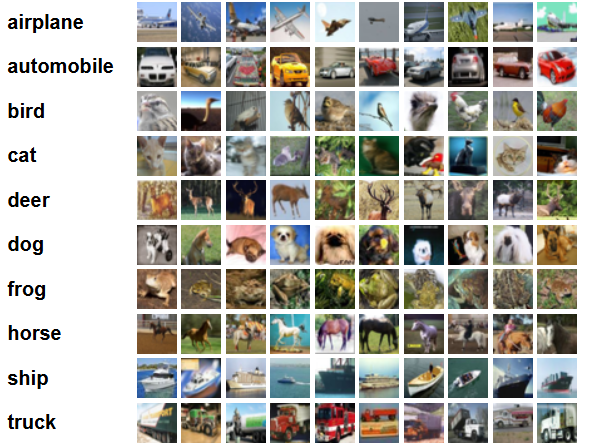

In [ ]:
# Function to create ResNet-based client and server models
def get_split_resnet_model(client_front_layers, server_layers, client_back_layers, output_classes=10):
    class ClientFrontModel(nn.Module):
        def __init__(self):
            super(ClientFrontModel, self).__init__()
            resnet = models.resnet18(pretrained=True)
            self.client_front = nn.Sequential(*list(resnet.children())[:client_front_layers])

        def forward(self, x):
            return self.client_front(x)

    class ServerModel(nn.Module):
        def __init__(self):
            super(ServerModel, self).__init__()
            resnet = models.resnet18(pretrained=True)
            self.server_part = nn.Sequential(*list(resnet.children())[client_front_layers:server_layers])

        def forward(self, x):
            return self.server_part(x)

    class ClientBackModel(nn.Module):
        def __init__(self):
            super(ClientBackModel, self).__init__()
            resnet = models.resnet18(pretrained=True)
            self.client_back = nn.Sequential(*list(resnet.children())[server_layers:client_back_layers])
            self.classifier = nn.Linear(512, output_classes)

        def forward(self, x):
            x = self.client_back(x)
            x = torch.flatten(x, 1)
            return self.classifier(x)

    return ClientFrontModel, ServerModel, ClientBackModel


ResNet-18 is a convolutional neural network that is 18 layers deep. You can load a pretrained version of the network trained on more than a million images from the ImageNet database. The pretrained network can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals. As a result, the network has learned rich feature representations for a wide range of images. The network has an image input size of 224X224.

ResNet Architecture [Link](https://www.researchgate.net/publication/366608244_CNN_Based_Image_Classification_of_Malicious_UAVs/figures?lo=1)

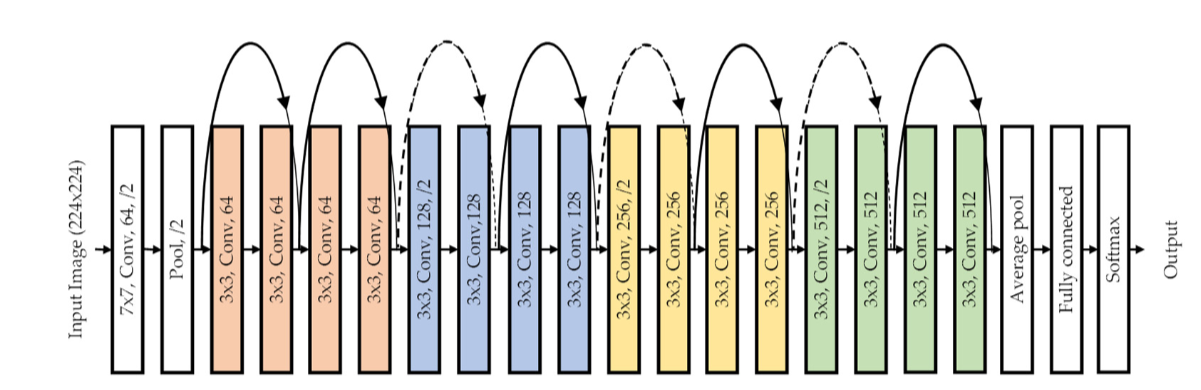

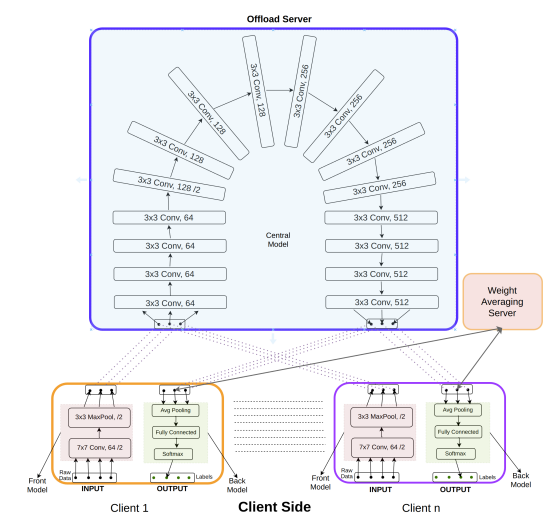

In [ ]:
# Function to train a client
def train_client_back(client_front, server, client_back, train_loader, criterion, optimizer, device, epochs=5):
    client_front.eval()  # Freeze the client front model
    server.eval()        # Freeze the server model
    client_back.train()  # Only train the client back model

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass through Client Front
            with torch.no_grad():
                intermediate_output = client_front(inputs)

            # Forward pass through Server
            with torch.no_grad():
                server_output = server(intermediate_output)

            # Forward pass through Client Back
            outputs = client_back(server_output)

            # Compute loss and backpropagation
            optimizer.zero_grad()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader):.4f}")


In [ ]:
# Federated averaging function
def federated_averaging_client_back(client_back_models, num_clients):
    averaged_state_dict = {
        key: torch.stack([client_back_models[c].state_dict()[key].float() for c in range(num_clients)]).mean(0)
        if client_back_models[0].state_dict()[key].dtype in [torch.float32, torch.float64] else client_back_models[0].state_dict()[key]
        for key in client_back_models[0].state_dict()
    }
    averaged_client_back = client_back_models[0].__class__()
    averaged_client_back.load_state_dict(averaged_state_dict)
    return averaged_client_back


In [ ]:
# Function to evaluate models
def evaluate_split_model(client_front, server, client_back, test_loader, device):
    client_front.eval()
    server.eval()
    client_back.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass through Client Front
            intermediate_output = client_front(inputs)

            # Forward pass through Server
            server_output = server(intermediate_output)

            # Forward pass through Client Back
            outputs = client_back(server_output)

            # Compute accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total


Split Learning (SL) is another collaborative learning approach in which an ML model
is split into two (or multiple) portions that can be trained separately but in collaboration.
The user device (client) executes the client-side model using its local data and sends the
intermediate results (outputs of the client-side model) to a server. The server uses the
received data as input to the server-side model to complete the forward propagation.
During the backpropagation, the gradients are computed at the server and then sent back
to the client to complete one training iteration. In a typical SL framework, multiple clients
collaborate with one server to train a global model using the private data available on
different user devices. SL allows user devices to offload part of the model training task to a
server thus making it possible to leverage flexible resource management in edge computing
for supporting ML model training. Therefore, SL may greatly facilitate the resource aspect
of ubiquitous intelligence in IoT. However, the sequential client-server collaboration in SL
limits its capability of involving the IoT big data dispersed across a large number of user
devices for model training.

Split Learning [Link](https://www.mdpi.com/1424-8220/22/16/5983)

In [ ]:
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_loaders, test_loader = get_datasets()

    # Get the models with the updated split
    ClientFront, ServerModel, ClientBack = get_split_resnet_model(1,-1, -1)

    num_clients = 5
    epochs = 5

    # Instantiate the models
    client_front_models = [ClientFront().to(device) for _ in range(num_clients)]
    server_models = [ServerModel().to(device) for _ in range(num_clients)]
    client_back_models = [ClientBack().to(device) for _ in range(num_clients)]

    criterion = nn.CrossEntropyLoss()

    # Train only the client back part
    for client_id in range(num_clients):
        print(f"\nTraining Client Back for Client {client_id + 1}")
        client_back_optimizer = optim.SGD(client_back_models[client_id].parameters(), lr=0.001, momentum=0.9)
        train_client_back(
            client_front_models[client_id],
            server_models[client_id],
            client_back_models[client_id],
            train_loaders[client_id],
            criterion,
            client_back_optimizer,
            device,
            epochs
        )

    # Federated Averaging for Client Back Models
    averaged_client_back_model = federated_averaging_client_back(client_back_models, num_clients).to(device)

    # Evaluate individual client models
    print("\nEvaluating Individual Client Models")
    for client_id in range(num_clients):
        accuracy = evaluate_split_model(client_front_models[client_id], server_models[client_id], client_back_models[client_id], test_loader, device)
        print(f"Client {client_id + 1} Accuracy: {accuracy:.2f}%")

    # Evaluate averaged client back model
    print("\nEvaluating Averaged Client Back Model")
    average_accuracy = evaluate_split_model(client_front_models[0], server_models[0], averaged_client_back_model, test_loader, device)
    print(f"Averaged Client Back Model Accuracy: {average_accuracy:.2f}%")


Files already downloaded and verified
Files already downloaded and verified

Training Client Back for Client 1
Epoch 1, Loss: 2.3322
Epoch 2, Loss: 1.8176
Epoch 3, Loss: 1.3883
Epoch 4, Loss: 1.1474
Epoch 5, Loss: 0.9784

Training Client Back for Client 2
Epoch 1, Loss: 2.2997
Epoch 2, Loss: 1.7736
Epoch 3, Loss: 1.4036
Epoch 4, Loss: 1.1467
Epoch 5, Loss: 0.9866

Training Client Back for Client 3
Epoch 1, Loss: 2.2660
Epoch 2, Loss: 1.7796
Epoch 3, Loss: 1.3688
Epoch 4, Loss: 1.1004
Epoch 5, Loss: 0.9257

Training Client Back for Client 4
Epoch 1, Loss: 2.2553
Epoch 2, Loss: 1.7846
Epoch 3, Loss: 1.4142
Epoch 4, Loss: 1.1853
Epoch 5, Loss: 1.0287

Training Client Back for Client 5
Epoch 1, Loss: 2.3491
Epoch 2, Loss: 1.8019
Epoch 3, Loss: 1.4061
Epoch 4, Loss: 1.1475
Epoch 5, Loss: 0.9947

Evaluating Individual Client Models
Client 1 Accuracy: 66.00%
Client 2 Accuracy: 70.00%
Client 3 Accuracy: 76.00%
Client 4 Accuracy: 68.00%
Client 5 Accuracy: 76.00%

Evaluating Averaged Client Back